# The result will be like this <br>


1.   Title : title of the page 
2.   URL
3.   Level 1 - 3 : Your datalayer levels
4.   Last modification : the last modification of your page if provided on sitemap
5.   Info for tag management 




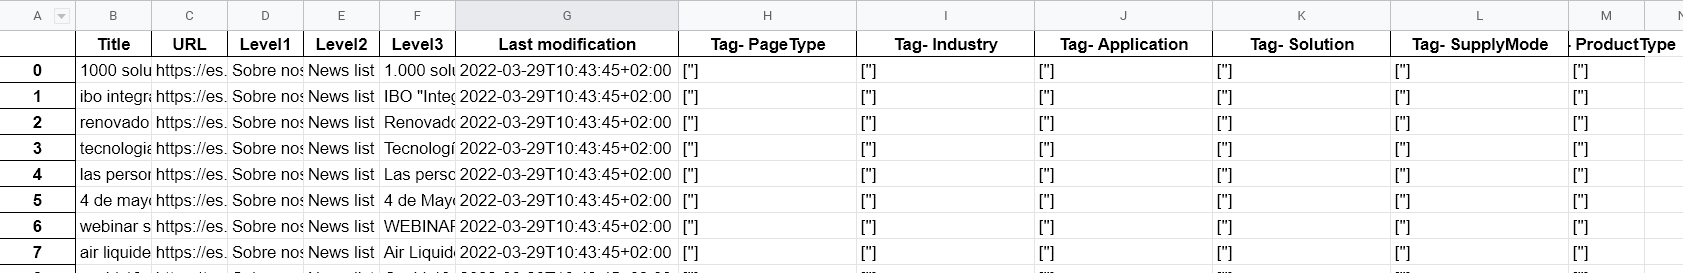

In [81]:
import urllib.request as req
import time 
from fake_useragent import UserAgent
import string
import bs4
import json
import scrapy
import pandas as pd
import re
import requests

# **Get the URLs from sitemap** <br>
By entering the *Sitemap.xml* of your site, we need to collect all the URLs of each page.

In [ ]:
#Get the URLs from sitemap
def get_site_map_all(url):
  ua = UserAgent()
  user_agent = ua.random
  request = req.Request(url, headers ={'User-Agent':user_agent})
  with req.urlopen(request) as response :
        data=response.read().decode('utf-8','ignore') 
        v =bs4.BeautifulSoup(data, 'html.parser')

  ES = v.find_all('url') 
  ES= list(ES)
  list_urls=[]
  resultss = []
  for yuyu in ES:
    table = {}
    title = yuyu.find('loc').getText().split('/')[-1]
    title = title.replace('-',' ')
    table['Title'] = title
    table['URL'] = yuyu.find('loc').getText()
    list_urls.append(yuyu.find('loc').getText())
    for hao in yuyu.find_all(href=True):
      key =hao["hreflang"]
      table[key] = hao["href"]
    
    resultss.append(table)
  
  return resultss,list_urls,table

# **Get the DataLayer information:** <br>
After collecting all the URLs, we need to find out the part of code of the Datalayer on the site. <br>
In this case, it locates at *script[type=application/ld+json]* <br>
Remember to adapte as yours !

In [ ]:
#Content in english site
def yuyu_visiting_site_eng(URLS):
  ua = UserAgent()
  user_agent = ua.random
  #print(URLS)
  table = {}
  request = req.Request(URLS, headers ={'User-Agent':user_agent})
  response = requests.get(URLS, allow_redirects=False).status_code
  time.sleep(0.00000001)

  try:
      with req.urlopen(request) as response :
          data=response.read().decode('utf-8','ignore') 
          roots =bs4.BeautifulSoup(data, 'html.parser')
          if roots.select_one("script[type=application/ld+json]") != None:
              datass = [json.loads(x.string) for x in roots.find_all("script", type="application/ld+json")]
              #table['Last modification'] = roots.find('lastmod').getText()
              table['Title'] = URLS.split('/')[-1].replace('-',' ')
              table['URL'] = URLS
              for i in datass:
                  x=i.get("itemListElement", "")
                  for i in x:
                    jj=i.get('position')
                    jxj=i.get('name')
                    table[i['position']] = i['name']
      return table
  except:
        table['Title'] = 'Cannot reach this'
        table['URL'] = URLS
        print("\n")
        print('Cannot reach this:',URLS,response)
        return table

# **Run the code and save them into a dataframe**

In [ ]:
d = get_site_map_all(URL)
resultss = d[0]
list_urls = d[1]

r = []
count= 0
print('Total pages : ',len(list_urls))
print('Now processing : ')
for i in list_urls: 
  table = yuyu_visiting_site_eng(i)
  if table == None:
     continue
  r.append(table)
  count = count + 1
  print(count, end =" ")
  if(count%50==0):
    print("\n")


all_web =pd.DataFrame(r)
all_country = pd.DataFrame(resultss)
New = all_web.merge(all_country, how='inner',on='URL')
newcc ={1:'Level',2:'Level1',3:'Level2',4:'Level3',5:'Level4',6:'Level5'}
New=New.rename(columns=newcc)
New=New.drop(['Level'], axis=1)

cols = list(New)
New = New[cols[6:] + cols [0:6]]


*Optional : save and download from colab*


In [ ]:
from google.colab import files
with open('New.txt', 'w') as f:
  New.to_csv(f)

files.download('New.txt')
print('Terminé !')